In [5]:
from __future__ import print_function
import time

import numpy as np
np.random.seed(1234)
from functools import reduce
import math as m

import scipy.io
#import theano
#import theano.tensor as T

from scipy.interpolate import griddata
from sklearn.preprocessing import scale
#from utils import augment_EEG, cart2sph, pol2cart

#import lasagne
# from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
#from lasagne.layers import Conv2DLayer, MaxPool2DLayer, InputLayer
#from lasagne.layers import DenseLayer, ElemwiseMergeLayer, FlattenLayer
#from lasagne.layers import ConcatLayer, ReshapeLayer, get_output_shape
#from lasagne.layers import Conv1DLayer, DimshuffleLayer, LSTMLayer, SliceLayer


def azim_proj(pos):
    """
    Computes the Azimuthal Equidistant Projection of input point in 3D Cartesian Coordinates.
    Imagine a plane being placed against (tangent to) a globe. If
    a light source inside the globe projects the graticule onto
    the plane the result would be a planar, or azimuthal, map
    projection.

    :param pos: position in 3D Cartesian coordinates
    :return: projected coordinates using Azimuthal Equidistant Projection
    """
    [r, elev, az] = cart2sph(pos[0], pos[1], pos[2])
    return pol2cart(az, m.pi / 2 - elev)


def gen_images(locs, features, n_gridpoints, normalize=True,
               augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode

    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each band over all samples
    :param augment:     Flag for generating augmented images
    :param pca:         Flag for PCA based data augmentation
    :param std_mult     Multiplier for std of added noise
    :param n_components: Number of components in PCA to retain for augmentation
    :param edgeless:    If True generates edgeless images by adding artificial channels
                        at four corners of the image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes
    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = features.shape[1] / nElectrodes
    for c in range(int(n_colors)):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])
    if augment:
        if pca:
            for c in range(int(n_colors)):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=True, n_components=n_components)
        else:
            for c in range(int(n_colors)):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=False, n_components=n_components)
    nSamples = features.shape[0]
    # Interpolate the values
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
                     ]
    temp_interp = []
    for c in range(int(n_colors)):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))
    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y],[max_x, min_y],[max_x, max_y]]),axis=0)
        for c in range(int(n_colors)):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)
    # Interpolating
    for i in range(int(nSamples)):
        for c in range(int(n_colors)):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),
                                    method='cubic', fill_value=np.nan)
        print('Interpolating {0}/{1}\r'.format(i+1, nSamples), end='\r')
    # Normalizing
    for c in range(int(n_colors)):
        if normalize:
            temp_interp[c][~np.isnan(temp_interp[c])] = \
                scale(temp_interp[c][~np.isnan(temp_interp[c])])
        temp_interp[c] = np.nan_to_num(temp_interp[c])
    return np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H]


def build_cnn(input_var=None, w_init=None, n_layers=(4, 2, 1), n_filters_first=32, imsize=32, n_colors=3):
    """
    Builds a VGG style CNN network followed by a fully-connected layer and a softmax layer.
    Stacks are separated by a maxpool layer. Number of kernels in each layer is twice
    the number in previous stack.
    input_var: Theano variable for input to the network
    outputs: pointer to the output of the last layer of network (softmax)

    :param input_var: theano variable as input to the network
    :param w_init: Initial weight values
    :param n_layers: number of layers in each stack. An array of integers with each
                    value corresponding to the number of layers in each stack.
                    (e.g. [4, 2, 1] == 3 stacks with 4, 2, and 1 layers in each.
    :param n_filters_first: number of filters in the first layer
    :param imSize: Size of the image
    :param n_colors: Number of color channels (depth)
    :return: a pointer to the output of last layer
    """
    weights = []        # Keeps the weights for all layers
    count = 0
    # If no initial weight is given, initialize with GlorotUniform
    if w_init is None:
        w_init = [lasagne.init.GlorotUniform()] * sum(n_layers)
    # Input layer
    network = InputLayer(shape=(None, n_colors, imsize, imsize),
                                        input_var=input_var)
    for i, s in enumerate(n_layers):
        for l in range(s):
            network = Conv2DLayer(network, num_filters=n_filters_first * (2 ** i), filter_size=(3, 3),
                          W=w_init[count], pad='same')
            count += 1
            weights.append(network.W)
        network = MaxPool2DLayer(network, pool_size=(2, 2))
    return network, weights


def build_convpool_max(input_vars, nb_classes, imsize=32, n_colors=3, n_timewin=3):
    """
    Builds the complete network with maxpooling layer in time.

    :param input_vars: list of EEG images (one image per time window)
    :param nb_classes: number of classes
    :param imsize: size of the input image (assumes a square input)
    :param n_colors: number of color channels in the image
    :param n_timewin: number of time windows in the snippet
    :return: a pointer to the output of last layer
    """
    convnets = []
    w_init = None
    # Build 7 parallel CNNs with shared weights
    for i in range(n_timewin):
        if i == 0:
            convnet, w_init = build_cnn(input_vars[i], imsize=imsize, n_colors=n_colors)
        else:
            convnet, _ = build_cnn(input_vars[i], w_init=w_init, imsize=imsize, n_colors=n_colors)
        convnets.append(convnet)
    # convpooling using Max pooling over frames
    convpool = ElemwiseMergeLayer(convnets, theano.tensor.maximum)
    # A fully-connected layer of 512 units with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=512, nonlinearity=lasagne.nonlinearities.rectify)
    # And, finally, the output layer with 50% dropout on its inputs:
    convpool = lasagne.layers.DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=nb_classes, nonlinearity=lasagne.nonlinearities.softmax)
    return convpool


def build_convpool_conv1d(input_vars, nb_classes, imsize=32, n_colors=3, n_timewin=3):
    """
    Builds the complete network with 1D-conv layer to integrate time from sequences of EEG images.

    :param input_vars: list of EEG images (one image per time window)
    :param nb_classes: number of classes
    :param imsize: size of the input image (assumes a square input)
    :param n_colors: number of color channels in the image
    :param n_timewin: number of time windows in the snippet
    :return: a pointer to the output of last layer
    """
    convnets = []
    w_init = None
    # Build 7 parallel CNNs with shared weights
    for i in range(n_timewin):
        if i == 0:
            convnet, w_init = build_cnn(input_vars[i], imsize=imsize, n_colors=n_colors)
        else:
            convnet, _ = build_cnn(input_vars[i], w_init=w_init, imsize=imsize, n_colors=n_colors)
        convnets.append(FlattenLayer(convnet))
    # at this point convnets shape is [numTimeWin][n_samples, features]
    # we want the shape to be [n_samples, features, numTimeWin]
    convpool = ConcatLayer(convnets)
    convpool = ReshapeLayer(convpool, ([0], n_timewin, get_output_shape(convnets[0])[1]))
    convpool = DimshuffleLayer(convpool, (0, 2, 1))
    # input to 1D convlayer should be in (batch_size, num_input_channels, input_length)
    convpool = Conv1DLayer(convpool, 64, 3)
    # A fully-connected layer of 512 units with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=512, nonlinearity=lasagne.nonlinearities.rectify)
    # And, finally, the output layer with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=nb_classes, nonlinearity=lasagne.nonlinearities.softmax)
    return convpool


def build_convpool_lstm(input_vars, nb_classes, grad_clip=110, imsize=32, n_colors=3, n_timewin=3):
    """
    Builds the complete network with LSTM layer to integrate time from sequences of EEG images.

    :param input_vars: list of EEG images (one image per time window)
    :param nb_classes: number of classes
    :param grad_clip:  the gradient messages are clipped to the given value during
                        the backward pass.
    :param imsize: size of the input image (assumes a square input)
    :param n_colors: number of color channels in the image
    :param n_timewin: number of time windows in the snippet
    :return: a pointer to the output of last layer
    """
    convnets = []
    w_init = None
    # Build 7 parallel CNNs with shared weights
    for i in range(n_timewin):
        if i == 0:
            convnet, w_init = build_cnn(input_vars[i], imsize=imsize, n_colors=n_colors)
        else:
            convnet, _ = build_cnn(input_vars[i], w_init=w_init, imsize=imsize, n_colors=n_colors)
        convnets.append(FlattenLayer(convnet))
    # at this point convnets shape is [numTimeWin][n_samples, features]
    # we want the shape to be [n_samples, features, numTimeWin]
    convpool = ConcatLayer(convnets)
    convpool = ReshapeLayer(convpool, ([0], n_timewin, get_output_shape(convnets[0])[1]))
    # Input to LSTM should have the shape as (batch size, SEQ_LENGTH, num_features)
    convpool = LSTMLayer(convpool, num_units=128, grad_clipping=grad_clip,
        nonlinearity=lasagne.nonlinearities.tanh)
    # We only need the final prediction, we isolate that quantity and feed it
    # to the next layer.
    convpool = SliceLayer(convpool, -1, 1)      # Selecting the last prediction
    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=256, nonlinearity=lasagne.nonlinearities.rectify)
    # And, finally, the output layer with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(convpool, p=.5),
            num_units=nb_classes, nonlinearity=lasagne.nonlinearities.softmax)
    return convpool


def build_convpool_mix(input_vars, nb_classes, grad_clip=110, imsize=32, n_colors=3, n_timewin=3):
    """
    Builds the complete network with LSTM and 1D-conv layers combined

    :param input_vars: list of EEG images (one image per time window)
    :param nb_classes: number of classes
    :param grad_clip:  the gradient messages are clipped to the given value during
                        the backward pass.
    :param imsize: size of the input image (assumes a square input)
    :param n_colors: number of color channels in the image
    :param n_timewin: number of time windows in the snippet
    :return: a pointer to the output of last layer
    """
    convnets = []
    w_init = None
    # Build 7 parallel CNNs with shared weights
    for i in range(n_timewin):
        if i == 0:
            convnet, w_init = build_cnn(input_vars[i], imsize=imsize, n_colors=n_colors)
        else:
            convnet, _ = build_cnn(input_vars[i], w_init=w_init, imsize=imsize, n_colors=n_colors)
        convnets.append(FlattenLayer(convnet))
    # at this point convnets shape is [numTimeWin][n_samples, features]
    # we want the shape to be [n_samples, features, numTimeWin]
    convpool = ConcatLayer(convnets)
    convpool = ReshapeLayer(convpool, ([0], n_timewin, get_output_shape(convnets[0])[1]))
    reformConvpool = DimshuffleLayer(convpool, (0, 2, 1))
    # input to 1D convlayer should be in (batch_size, num_input_channels, input_length)
    conv_out = Conv1DLayer(reformConvpool, 64, 3)
    conv_out = FlattenLayer(conv_out)
    # Input to LSTM should have the shape as (batch size, SEQ_LENGTH, num_features)
    lstm = LSTMLayer(convpool, num_units=128, grad_clipping=grad_clip,
        nonlinearity=lasagne.nonlinearities.tanh)
    lstm_out = SliceLayer(lstm, -1, 1)
    # Merge 1D-Conv and LSTM outputs
    dense_input = ConcatLayer([conv_out, lstm_out])
    # A fully-connected layer of 256 units with 50% dropout on its inputs:
    convpool = DenseLayer(lasagne.layers.dropout(dense_input, p=.5),
            num_units=512, nonlinearity=lasagne.nonlinearities.rectify)
    # And, finally, the 10-unit output layer with 50% dropout on its inputs:
    convpool = DenseLayer(convpool,
            num_units=nb_classes, nonlinearity=lasagne.nonlinearities.softmax)
    return convpool


def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    """
    Iterates over the samples returing batches of size batchsize.
    :param inputs: input data array. It should be a 4D numpy array for images [n_samples, n_colors, W, H] and 5D numpy
                    array if working with sequence of images [n_timewindows, n_samples, n_colors, W, H].
    :param targets: vector of target labels.
    :param batchsize: Batch size
    :param shuffle: Flag whether to shuffle the samples before iterating or not.
    :return: images and labels for a batch
    """
    if inputs.ndim == 4:
        input_len = inputs.shape[0]
    elif inputs.ndim == 5:
        input_len = inputs.shape[1]
    assert input_len == len(targets)
    if shuffle:
        indices = np.arange(input_len)
        np.random.shuffle(indices)
    for start_idx in range(0, input_len, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        if inputs.ndim == 4:
            yield inputs[excerpt], targets[excerpt]
        elif inputs.ndim == 5:
            yield inputs[:, excerpt], targets[excerpt]


def train(images, labels, fold, model_type, batch_size=32, num_epochs=5):
    """
    A sample training function which loops over the training set and evaluates the network
    on the validation set after each epoch. Evaluates the network on the training set
    whenever the
    :param images: input images
    :param labels: target labels
    :param fold: tuple of (train, test) index numbers
    :param model_type: model type ('cnn', '1dconv', 'maxpool', 'lstm', 'mix')
    :param batch_size: batch size for training
    :param num_epochs: number of epochs of dataset to go over for training
    :return: none
    """
    num_classes = len(np.unique(labels))
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = reformatInput(images, labels, fold)
    X_train = X_train.astype("float32", casting='unsafe')
    X_val = X_val.astype("float32", casting='unsafe')
    X_test = X_test.astype("float32", casting='unsafe')
    # Prepare Theano variables for inputs and targets
    input_var = T.TensorType('floatX', ((False,) * 5))()
    target_var = T.ivector('targets')
    # Create neural network model (depending on first command line parameter)
    print("Building model and compiling functions...")
    # Building the appropriate model
    if model_type == '1dconv':
        network = build_convpool_conv1d(input_var, num_classes)
    elif model_type == 'maxpool':
        network = build_convpool_max(input_var, num_classes)
    elif model_type == 'lstm':
        network = build_convpool_lstm(input_var, num_classes, 100)
    elif model_type == 'mix':
        network = build_convpool_mix(input_var, num_classes, 100)
    elif model_type == 'cnn':
        input_var = T.tensor4('inputs')
        network, _ = build_cnn(input_var)
        network = DenseLayer(lasagne.layers.dropout(network, p=.5),
                             num_units=256,
                             nonlinearity=lasagne.nonlinearities.rectify)
        network = DenseLayer(lasagne.layers.dropout(network, p=.5),
                             num_units=num_classes,
                             nonlinearity=lasagne.nonlinearities.softmax)
    else:
        raise ValueError("Model not supported ['1dconv', 'maxpool', 'lstm', 'mix', 'cnn']")
    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
    loss = loss.mean()
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.adam(loss, params, learning_rate=0.001)
    # Create a loss expression for validation/testing. The crucial difference
    # here is that we do a deterministic forward pass through the network,
    # disabling dropout layers.
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss = lasagne.objectives.categorical_crossentropy(test_prediction,
                                                            target_var)
    test_loss = test_loss.mean()
    # As a bonus, also create an expression for the classification accuracy:
    test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                      dtype=theano.config.floatX)
    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates)
    # Compile a second function computing the validation loss and accuracy:
    val_fn = theano.function([input_var, target_var], [test_loss, test_acc])
    # Finally, launch the training loop.
    print("Starting training...")
    best_validation_accu = 0
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=False):
            inputs, targets = batch
            train_err += train_fn(inputs, targets)
            train_batches += 1
        # And a full pass over the validation data:
        val_err = 0
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
            inputs, targets = batch
            err, acc = val_fn(inputs, targets)
            val_err += err
            val_acc += acc
            val_batches += 1
        av_train_err = train_err / train_batches
        av_val_err = val_err / val_batches
        av_val_acc = val_acc / val_batches
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(av_train_err))
        print("  validation loss:\t\t{:.6f}".format(av_val_err))
        print("  validation accuracy:\t\t{:.2f} %".format(av_val_acc * 100))
        if av_val_acc > best_validation_accu:
            best_validation_accu = av_val_acc
            # After training, we compute and print the test error:
            test_err = 0
            test_acc = 0
            test_batches = 0
            for batch in iterate_minibatches(X_test, y_test, batch_size, shuffle=False):
                inputs, targets = batch
                err, acc = val_fn(inputs, targets)
                test_err += err
                test_acc += acc
                test_batches += 1
            av_test_err = test_err / test_batches
            av_test_acc = test_acc / test_batches
            print("Final results:")
            print("  test loss:\t\t\t{:.6f}".format(av_test_err))
            print("  test accuracy:\t\t{:.2f} %".format(av_test_acc * 100))
            # Dump the network weights to a file like this:
            np.savez('weights_lasg_{0}'.format(model_type), *lasagne.layers.get_all_param_values(network))
    print('-'*50)
    print("Best validation accuracy:\t\t{:.2f} %".format(best_validation_accu * 100))
    print("Best test accuracy:\t\t{:.2f} %".format(av_test_acc * 100))

'''
if __name__ == '__main__':
    from utils import reformatInput

    # Load electrode locations
    print('Loading data...')
    locs = scipy.io.loadmat('../Sample data/Neuroscan_locs_orig.mat')
    locs_3d = locs['A']
    locs_2d = []
    # Convert to 2D
    for e in locs_3d:
        locs_2d.append(azim_proj(e))

    feats = scipy.io.loadmat('../Sample data/FeatureMat_timeWin.mat')['features']
    print ('Feats Shape: ',feats.shape)
    subj_nums = np.squeeze(scipy.io.loadmat('../Sample data/trials_subNums.mat')['subjectNum'])
    # Leave-Subject-Out cross validation
    fold_pairs = []
    for i in np.unique(subj_nums):
        ts = subj_nums == i
        tr = np.squeeze(np.nonzero(np.bitwise_not(ts)))
        ts = np.squeeze(np.nonzero(ts))
        np.random.shuffle(tr)  # Shuffle indices
        np.random.shuffle(ts)
        fold_pairs.append((tr, ts))

    # CNN Mode
    print('Generating images...')
    # Find the average response over time windows
    av_feats = reduce(lambda x, y: x+y, [feats[:, i*192:(i+1)*192] for i in range(feats.shape[1] / 192)])
    av_feats = av_feats / (feats.shape[1] / 192)
    images = gen_images(np.array(locs_2d),
                                  av_feats,
                                  32, normalize=False)
    print('\n')

    # Class labels should start from 0
    print('Training the CNN Model...')
    train(images, np.squeeze(feats[:, -1]) - 1, fold_pairs[2], 'cnn')

    # Conv-LSTM Mode
    print('Generating images for all time windows...')
    images_timewin = np.array([gen_images(np.array(locs_2d),
                                                    feats[:, i * 192:(i + 1) * 192], 32, normalize=False) for i in
                                         range(feats.shape[1] / 192)
                                         ])
    print('\n')
    print('Training the LSTM-CONV Model...')
    train(images_timewin, np.squeeze(feats[:, -1]) - 1, fold_pairs[2], 'mix')

    print('Done!')
'''

"\nif __name__ == '__main__':\n    from utils import reformatInput\n\n    # Load electrode locations\n    print('Loading data...')\n    locs = scipy.io.loadmat('../Sample data/Neuroscan_locs_orig.mat')\n    locs_3d = locs['A']\n    locs_2d = []\n    # Convert to 2D\n    for e in locs_3d:\n        locs_2d.append(azim_proj(e))\n\n    feats = scipy.io.loadmat('../Sample data/FeatureMat_timeWin.mat')['features']\n    print ('Feats Shape: ',feats.shape)\n    subj_nums = np.squeeze(scipy.io.loadmat('../Sample data/trials_subNums.mat')['subjectNum'])\n    # Leave-Subject-Out cross validation\n    fold_pairs = []\n    for i in np.unique(subj_nums):\n        ts = subj_nums == i\n        tr = np.squeeze(np.nonzero(np.bitwise_not(ts)))\n        ts = np.squeeze(np.nonzero(ts))\n        np.random.shuffle(tr)  # Shuffle indices\n        np.random.shuffle(ts)\n        fold_pairs.append((tr, ts))\n\n    # CNN Mode\n    print('Generating images...')\n    # Find the average response over time windows\n 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re

%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4

In [7]:

data = pd.read_csv('./data/data_16/15_data_1_label0.csv')
data.columns = range(14)

In [8]:
data.shape

(4761, 14)

In [9]:
df = pd.DataFrame(data)

In [10]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,4195.6411,4198.9741,4205.0000,4188.9741,4214.3589,4208.9741,4190.7690,4194.2310,4197.5640,4197.6924,4199.1025,4216.7949,4216.6665,4204.4873
1,4199.2310,4202.6924,4206.4102,4191.0259,4213.7178,4216.6665,4199.6152,4201.5386,4201.7949,4200.5127,4208.9741,4225.1284,4189.3589,4208.9741
2,4202.1797,4209.3589,4204.8716,4201.6665,4210.3848,4216.1538,4209.3589,4204.1025,4210.5127,4211.5386,4219.1025,4231.0259,4186.6665,4210.7690
3,4193.8462,4210.7690,4201.1538,4198.9741,4209.6152,4213.0771,4211.0259,4204.2310,4214.2310,4216.2822,4214.1025,4221.9229,4146.5386,4203.5898
4,4188.0771,4213.4614,4200.6411,4191.9229,4213.7178,4215.7690,4209.7437,4204.3589,4210.5127,4216.6665,4207.0513,4215.5127,4145.1284,4198.8462


In [11]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
count,4761.0000,4761.0000,4761.0000,4761.0000,4761.0000,4761.0000,4761.0000,4761.0000,4761.0000,4761.0000,4761.0000,4761.0000,4761.0000,4761.0000
mean,4207.6040,4206.8736,4206.1303,4207.3520,4206.7381,4205.2811,4205.8724,4207.9265,4207.7401,4208.3728,4207.4365,4215.3196,4205.5074,4206.3700
std,21.7513,22.5714,14.0292,19.1454,10.0527,11.6372,12.7957,24.4709,11.7145,18.0939,19.9235,15.5187,211.4969,24.8599
min,4119.1025,4131.4102,4150.2563,4155.3848,4167.3076,4162.9487,4151.0259,4012.5642,4153.4614,4121.4102,4104.4873,4149.4873,3398.8462,4088.7180
25%,4196.6665,4197.5640,4198.3335,4196.7949,4200.2383,4198.2051,4198.2051,4199.1025,4200.3848,4198.8462,4198.0771,4204.4873,4113.4614,4196.4102
50%,4207.9487,4204.3589,4205.8975,4205.0000,4205.8975,4204.2310,4204.6152,4206.5386,4207.0513,4208.4614,4207.8203,4215.8975,4194.7437,4206.1538
75%,4219.3589,4216.4102,4215.7690,4217.3076,4214.6152,4213.4614,4215.3848,4218.2051,4215.7690,4218.4614,4217.9487,4225.5127,4282.6924,4218.5898
max,4294.4873,4327.9487,4254.6152,4330.0000,4242.4360,4252.0513,4251.1538,4299.3589,4251.9229,4279.3589,4315.6411,4281.7949,5707.1797,4294.2310


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4761 entries, 0 to 4760
Data columns (total 14 columns):
0     4761 non-null float64
1     4761 non-null float64
2     4761 non-null float64
3     4761 non-null float64
4     4761 non-null float64
5     4761 non-null float64
6     4761 non-null float64
7     4761 non-null float64
8     4761 non-null float64
9     4761 non-null float64
10    4761 non-null float64
11    4761 non-null float64
12    4761 non-null float64
13    4761 non-null float64
dtypes: float64(14)
memory usage: 520.9 KB


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """


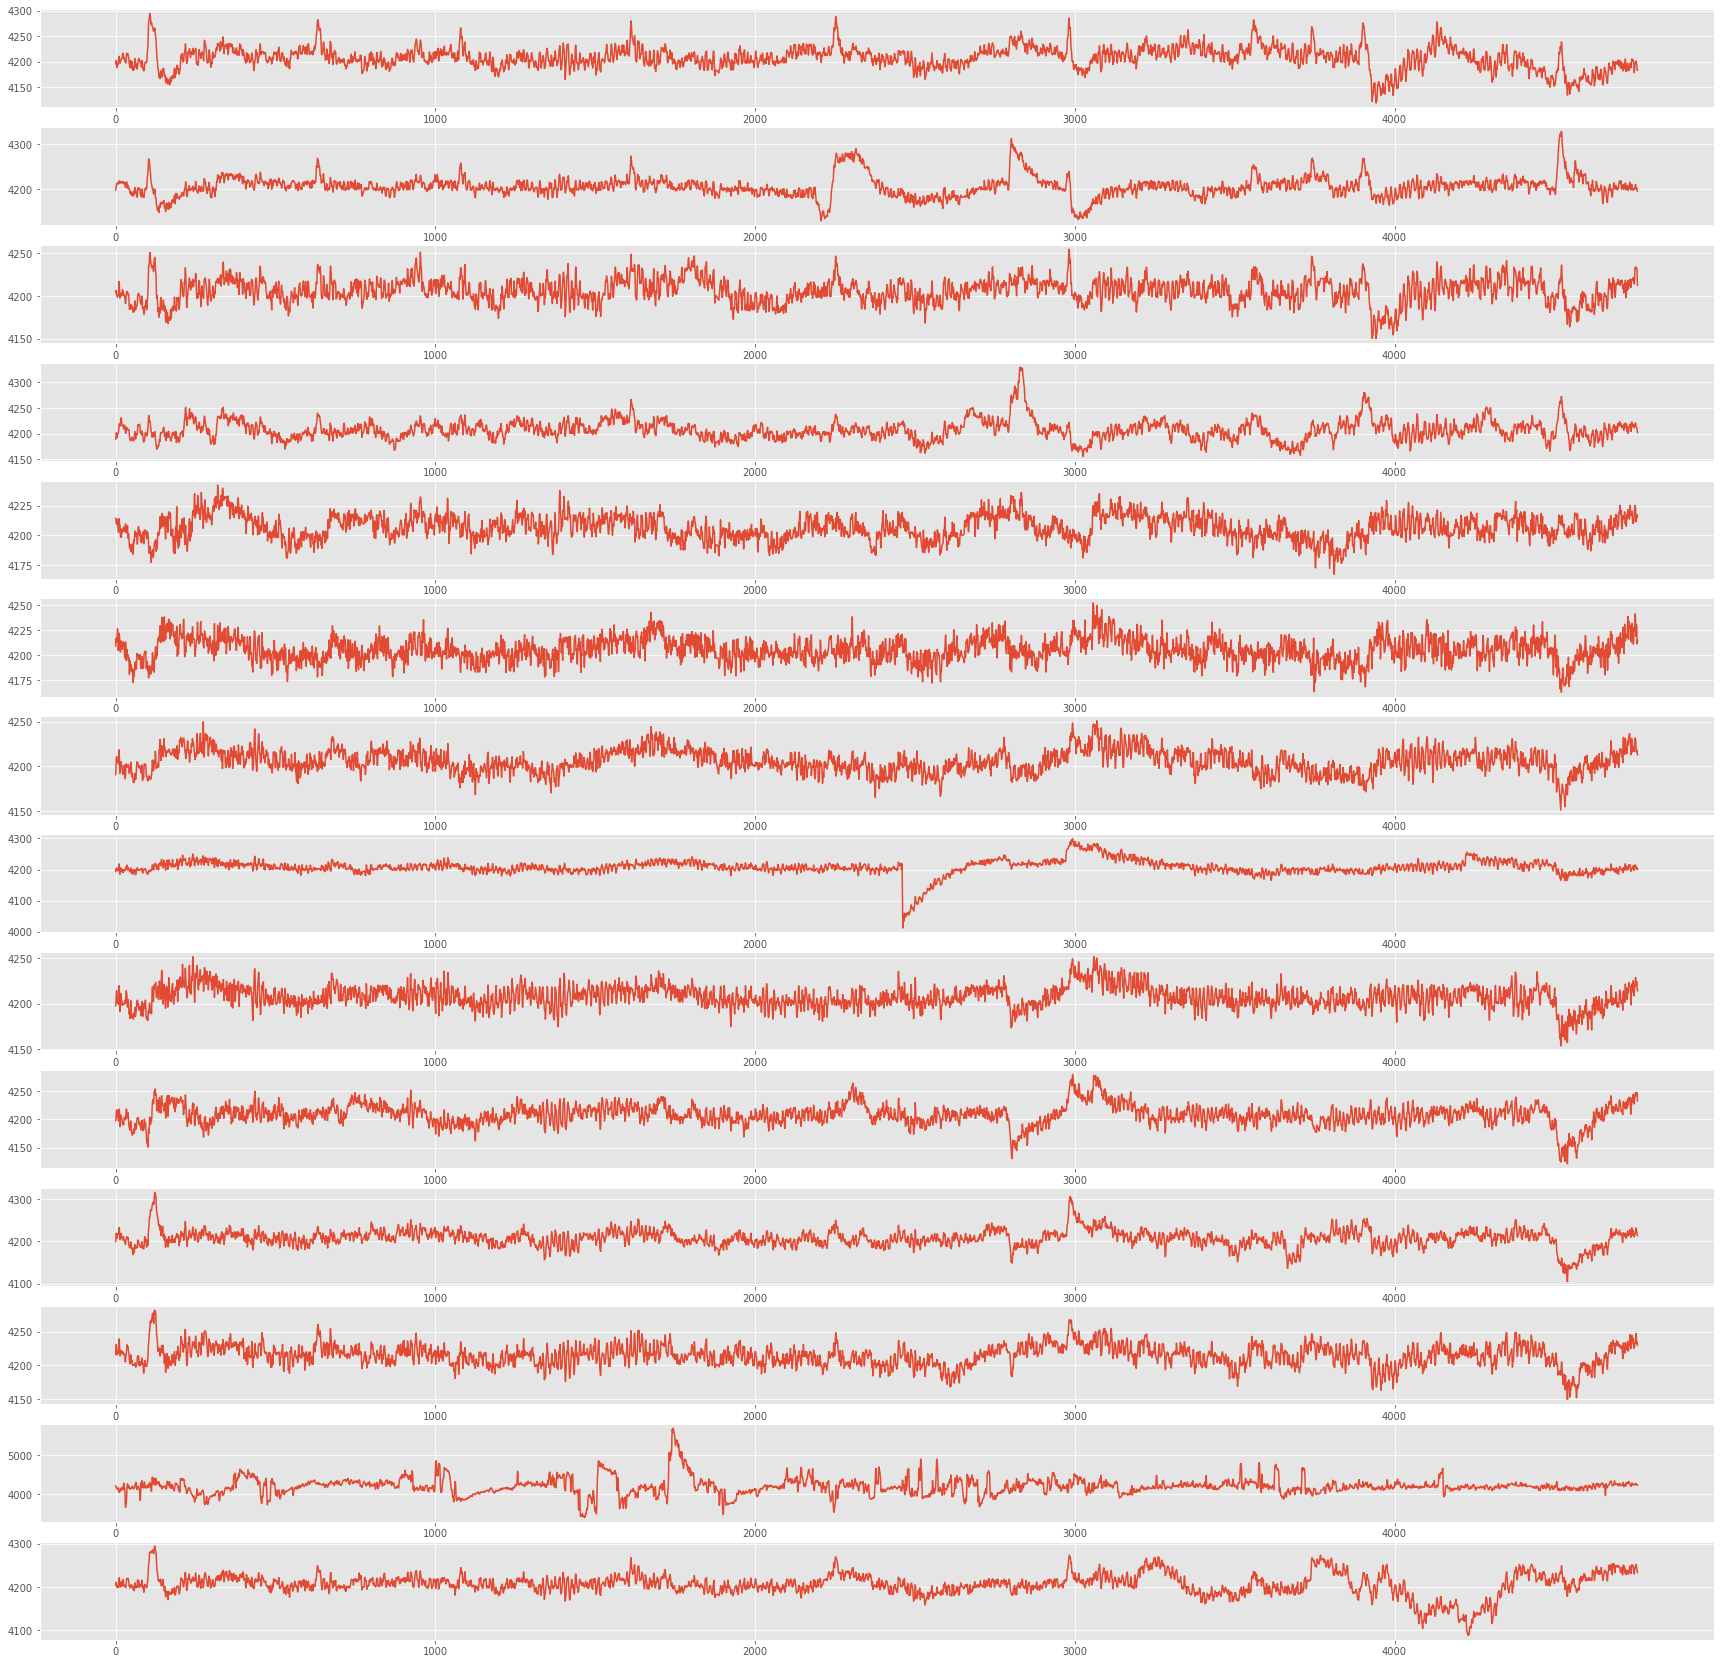

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(14, 1, figsize=(30,30))
for i, ax in enumerate(fig.axes):
    ax.plot(df.ix[:,i])
    #ax.set_xticks([])
    #ax.set_yticks([])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


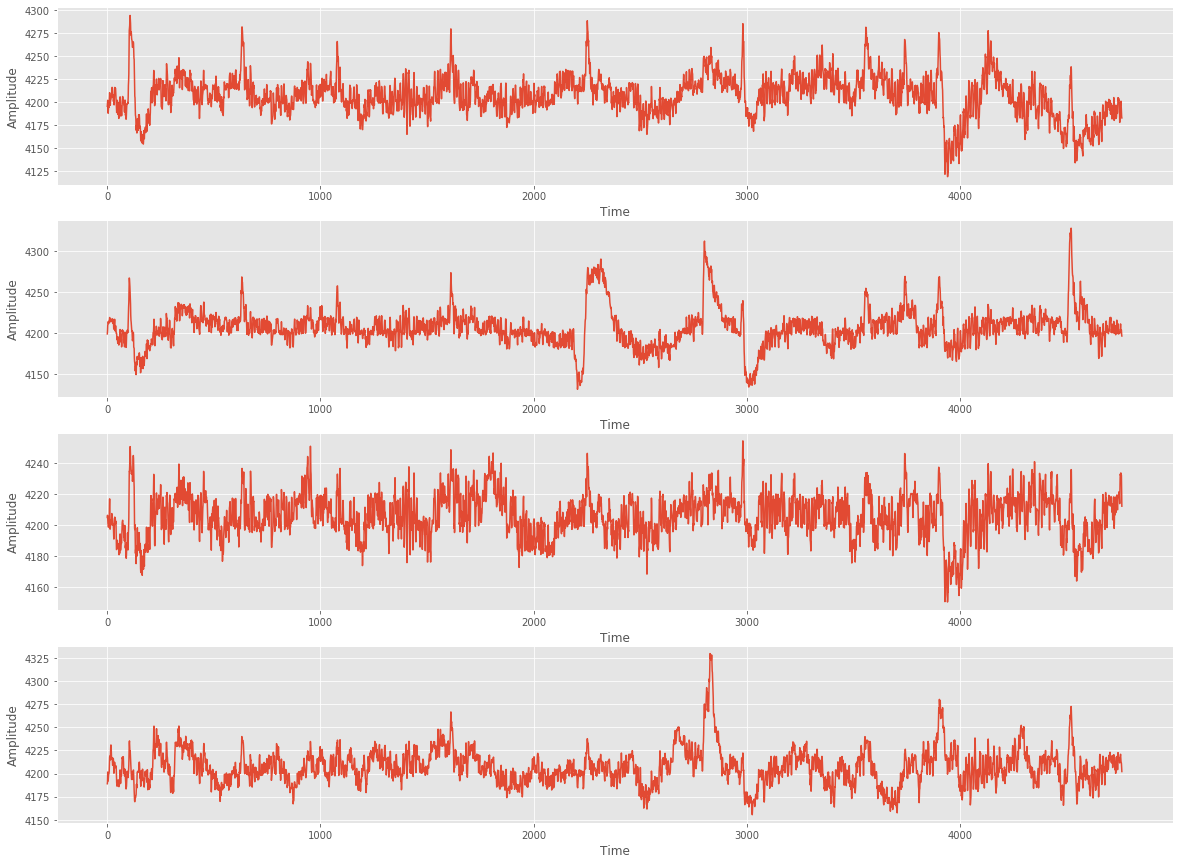

In [14]:
fig, axs = plt.subplots(4, 1, figsize=(20,15))

for i, ax in enumerate(fig.axes):
    ax.plot(df.ix[:,i])
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

#ax.set_xticks([])
#ax.set_yticks([])
plt.show()

In [15]:
snippet_0 = df.ix[:127,i]
snippet_1 = df.ix[127:255,i]
snippet_2 = df.ix[255:383,i]
snippet_3 = df.ix[383:511,i]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


(64,)
(64,)


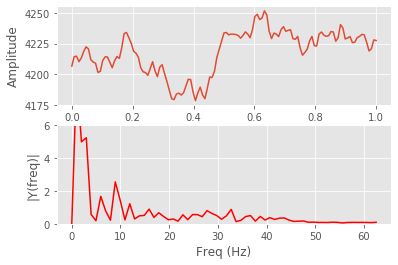

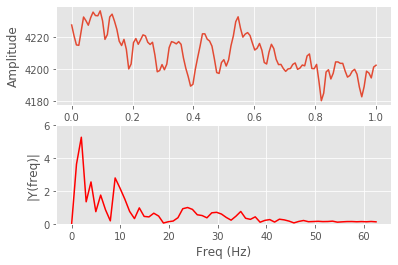

In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
def plot_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(int(n/2))]
    print(Y.shape)
    #Added in: (To remove bias.)
    Y[0] = 0

    fig, ax = plt.subplots(2, 1)
    ax[0].plot(t,y)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Amplitude')
    ax[1].set_ylim(0, 6)
    ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
    ax[1].set_xlabel('Freq (Hz)')
    ax[1].set_ylabel('|Y(freq)|');

    

plot_fft(snippet_2)
plot_fft(snippet_3)
#plot_url = plt.plot_mpl(fig, filename='mpl-basic-fft')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


(500,)


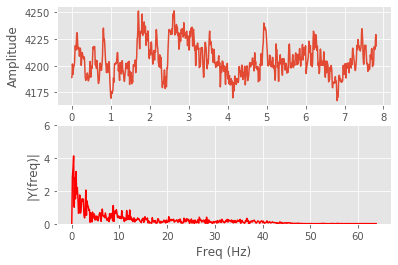

In [19]:
snippet = df.ix[:1000,i]
plot_fft(snippet)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


(500,)


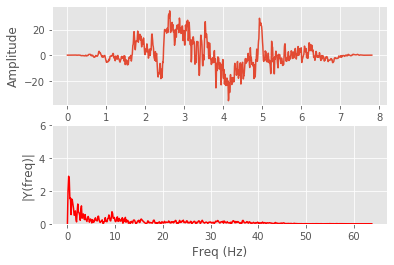

In [21]:
#Subtracting the mean and applying a hanning window.
snippet = df.ix[:1000,i]
snippet = snippet - np.mean(snippet)
np.hanning(len(snippet))
plot_fft(np.hanning(len(snippet))*snippet)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


(64,)


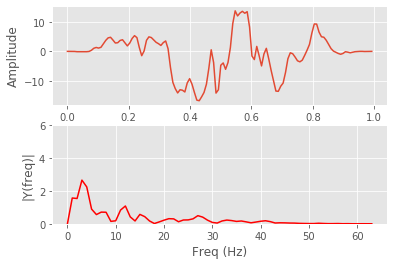

In [22]:
#Subtracting the mean and applying a hanning window.
snippet = df.ix[:127,i]
snippet = snippet - np.mean(snippet)
np.hanning(len(snippet))
plot_fft(np.hanning(len(snippet))*snippet)

## Brainwave Frequencies:
Gamma, 30 to 50 Hz.  
Beta, 14 to 30 Hz.  
Alpha, 8 to 14 Hz.  
Theta, 4 to 8 Hz.  
Delta, 0.1 to 4 Hz.  

## Changing Bin Size: 
https://stackoverflow.com/questions/25735153/plotting-a-fast-fourier-transform-in-python  
(Search for 'bin')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


(250,)


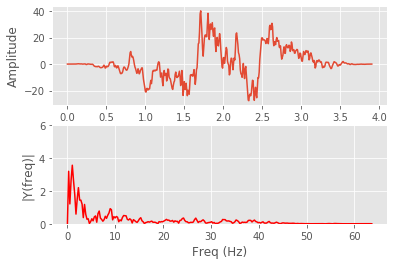

In [23]:
#Subtracting the mean and applying a hanning window.
snippet = df.ix[0:500,i]
snippet = snippet - np.mean(snippet)
np.hanning(len(snippet))
plot_fft(np.hanning(len(snippet))*snippet)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


(250,)


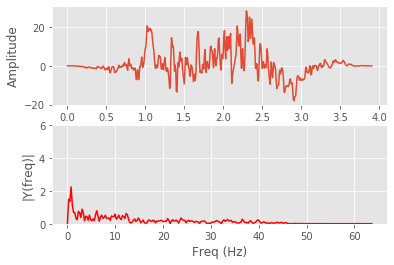

In [24]:
#Subtracting the mean and applying a hanning window.
snippet = df.ix[500:1000,i]
snippet = snippet - np.mean(snippet)
np.hanning(len(snippet))
plot_fft(np.hanning(len(snippet))*snippet)

An EEG processing library:  
https://github.com/pbashivan/EEGLearn

In [25]:
theta = (4,8)
alpha = (8,12)
beta = (12,40)

In [27]:
def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(int(n/2))]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)
f,Y = get_fft(np.hanning(len(snippet))*snippet)

In [28]:
f.shape

(250,)

In [29]:
Y[(f>theta[0]) & (f<=theta[1])].mean()

0.3909294451698333

In [30]:
f[(f>theta[0]) & (f<=theta[1])]

array([4.08782435, 4.34331337, 4.5988024 , 4.85429142, 5.10978044,
       5.36526946, 5.62075848, 5.8762475 , 6.13173653, 6.38722555,
       6.64271457, 6.89820359, 7.15369261, 7.40918164, 7.66467066,
       7.92015968])

In [31]:
def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

In [32]:
theta, alpha, beta = theta_alpha_beta_averages(f,Y)

In [33]:
theta, alpha, beta

(0.3909294451698333, 0.39171320641351776, 0.15675894975321092)

In [34]:
snippet = df.ix[:1000,i]
f,Y = get_fft(np.hanning(len(snippet))*snippet)
theta, alpha, beta = theta_alpha_beta_averages(f,Y)
theta, alpha, beta

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


(0.21540688864810392, 0.28480758052657745, 0.10066593387466893)

In [35]:
snippet = df.ix[500:1000,i]
f,Y = get_fft(np.hanning(len(snippet))*snippet)
theta, alpha, beta = theta_alpha_beta_averages(f,Y)
theta, alpha, beta

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


(0.39011917335886925, 0.39211201627465436, 0.1567711839441421)

In [36]:
snippet = df.ix[750:1000,i]
f,Y = get_fft(np.hanning(len(snippet))*snippet)
theta, alpha, beta = theta_alpha_beta_averages(f,Y)
theta, alpha, beta

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


(0.34033093674127257, 0.602832678429031, 0.18258084873774752)

In [37]:
snippet = df.ix[1750:1900,i]
f,Y = get_fft(np.hanning(len(snippet))*snippet)
theta, alpha, beta = theta_alpha_beta_averages(f,Y)
theta, alpha, beta

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


(0.7077380798719823, 0.8337814866301209, 0.21693764125920884)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4761 entries, 0 to 4760
Data columns (total 14 columns):
0     4761 non-null float64
1     4761 non-null float64
2     4761 non-null float64
3     4761 non-null float64
4     4761 non-null float64
5     4761 non-null float64
6     4761 non-null float64
7     4761 non-null float64
8     4761 non-null float64
9     4761 non-null float64
10    4761 non-null float64
11    4761 non-null float64
12    4761 non-null float64
13    4761 non-null float64
dtypes: float64(14)
memory usage: 520.9 KB


In [39]:
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = Fs*frame_duration
    frames = []
    steps = np.arange(0,len(df),frame_length)
    for i,_ in enumerate(steps):
        frame = []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.ix[steps[i-1]:steps[i]-1,int(channel)])
                #print(i, channel)
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                #print theta, alpha, beta
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
    return np.array(frames)

X = make_frames(df,1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


In [40]:
X.shape

(37, 14, 3)

In [43]:
X_1 = X.reshape(37,14*3)
X_1.shape

(37, 42)

In [44]:
Fs = 128.0
frame_length = Fs
np.arange(frame_length-1,len(df),frame_length)

array([ 127.,  255.,  383.,  511.,  639.,  767.,  895., 1023., 1151.,
       1279., 1407., 1535., 1663., 1791., 1919., 2047., 2175., 2303.,
       2431., 2559., 2687., 2815., 2943., 3071., 3199., 3327., 3455.,
       3583., 3711., 3839., 3967., 4095., 4223., 4351., 4479., 4607.,
       4735.])

In [45]:
steps = np.arange(0,len(df),frame_length)
steps

array([   0.,  128.,  256.,  384.,  512.,  640.,  768.,  896., 1024.,
       1152., 1280., 1408., 1536., 1664., 1792., 1920., 2048., 2176.,
       2304., 2432., 2560., 2688., 2816., 2944., 3072., 3200., 3328.,
       3456., 3584., 3712., 3840., 3968., 4096., 4224., 4352., 4480.,
       4608., 4736.])

In [46]:
snippet = df.ix[steps[0]:steps[1]-1,0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [47]:
len(snippet)

128

In [48]:
steps[i-1]

256.0

In [49]:
X_1.shape

(37, 42)

In [50]:
locs_2d = [(0.3365922112395738, -1.2361058792074007), (7.604101253680111e-17, -1.2418439763978288), 
           (-0.34374733394096496, -1.0016415369557565), (0.9157742224076064, -0.8516700268390739), 
           (0.22667265410177617, -0.693305669614743), (4.2303075026511913e-17, -0.6908616436341476), 
           (2.5666550686485195e-17, -0.41916658263191064), (-0.2557240551721939, -0.42833779241342484), 
           (-0.534287745073574, -0.4446918001304672), (-0.7936131740399253, -0.4555545752281128), 
           (0.21398122533036998, 0.38447594357747117), (2.272936032830068e-17, 0.3711986238665017), 
           (-0.48863672925399154, 0.7252902040103363), (1,1)]#(-0.6162746958262504, 0.8132625003849987),]


len(locs_2d)


14

In [93]:
locs_2d = [(-3.0,4.0),
           (2.0,4.0),
           (-2.0,2.0),
           (2.0,2.0),
           (-2.0,-2.0),
           (2.0,-2.0),
           (-4.0,1.0),
           (-1.0,3.0),
           (1.0,3.0),
           (-3.0,3.0),
           (3.0,3.0),
           
           (4.0,1.0),
           (-1.0,-3.0),
           (1.0,-3.0)]

In [94]:
min(np.array(locs_2d).T[1])

-3.0

In [95]:
images = gen_images(np.array(locs_2d),X_1, 32, normalize=True)

In [96]:
images[0, 0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


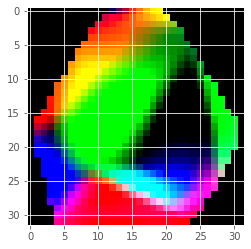

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(images[10].T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


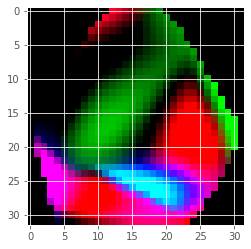

In [98]:
plt.imshow(images[1].T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


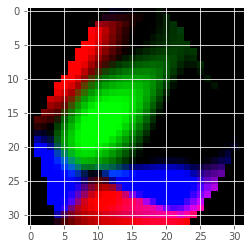

In [99]:
plt.imshow(images[2].T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


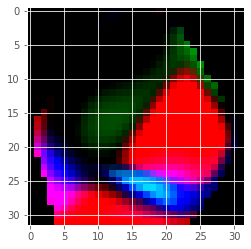

In [102]:
plt.imshow(images[4].T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


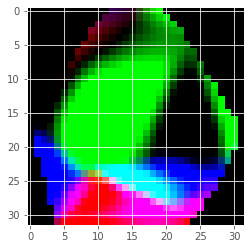

In [103]:
plt.imshow(images[11].T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


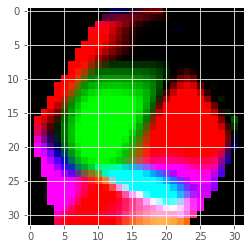

In [104]:
plt.imshow(images[12].T)

In [106]:
images[12].T[30]

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 2.07764105, -1.43768257,  0.71905435],
       [ 2.43568861, -1.32498495,  0.38953152],
       [ 2.7480203 , -1.21055195,  0.17723468],
       [ 2.9803179 , -1.0657212 ,  0.08370724],
       [ 3.1569802 , -0.89592291,  0.04945467],
       [ 3.28655428, -0.70894194,  0.0630582 ],
       [ 3.37758722, -0.51256317,  0.1130991 ],
       [ 3.44214998, -0.31649247,  0.18486758],
       [ 3.48819815, -0.1278285 ,  0.26791596],
       [ 3.51810578,  0.04955461,  0.35721859],
       [ 3.53424693,  0.21178277,  0.44774985],
       [ 3.53899564,  0.35498185,  0.53448411],
       [ 3.53472597,  0.47527776,  0.61239574],
       [ 3.52157026,  0.56917233,  0.67757894],
       [ 3.49433034,  0.63381512,  0.72850734],
       [ 3.45107428,  0.66557673,  0.76175688],
       [ 3.39007653,  0.66078812,  0.773

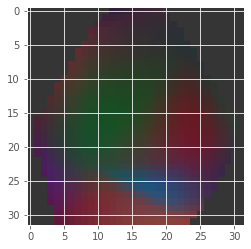

In [108]:
images[images<0].shape
images.shape
images_1 = images + -1*images.min()
images_1 = images_1/images_1.max()
images_1 = (images_1 * 255.0).astype('u1')

plt.imshow(images_1[12].T)

In [109]:
images_1[12].T[30]

array([[ 53,  53,  53],
       [ 53,  53,  53],
       [ 53,  53,  53],
       [ 53,  53,  53],
       [ 94,  25,  67],
       [101,  27,  61],
       [107,  29,  56],
       [111,  32,  55],
       [115,  36,  54],
       [117,  39,  54],
       [119,  43,  55],
       [120,  47,  57],
       [121,  51,  58],
       [122,  54,  60],
       [122,  57,  62],
       [122,  60,  63],
       [122,  62,  65],
       [122,  64,  66],
       [121,  65,  67],
       [120,  66,  68],
       [119,  66,  68],
       [117,  65,  69],
       [110,  66,  73],
       [112,  62,  69],
       [114,  57,  64],
       [ 53,  53,  53],
       [ 53,  53,  53],
       [ 53,  53,  53],
       [ 53,  53,  53],
       [ 53,  53,  53],
       [ 53,  53,  53],
       [ 53,  53,  53]], dtype=uint8)

In [110]:
images_1.shape

(37, 3, 32, 32)

NameError: name 'X' is not defined

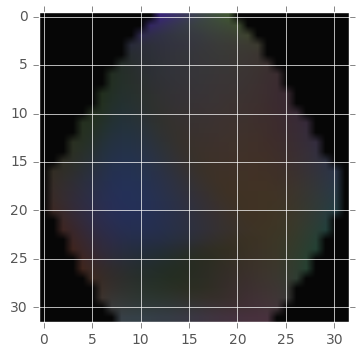

In [56]:
plt.imshow(images_1[0].T)

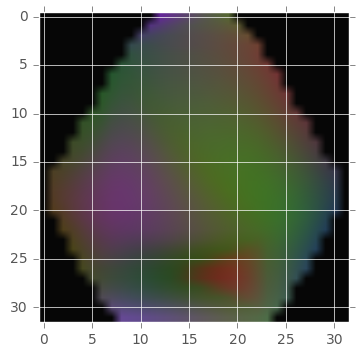

In [57]:
plt.imshow(images_1[1].T)

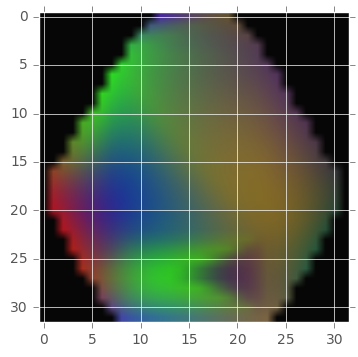

In [58]:
plt.imshow(images_1[2].T)

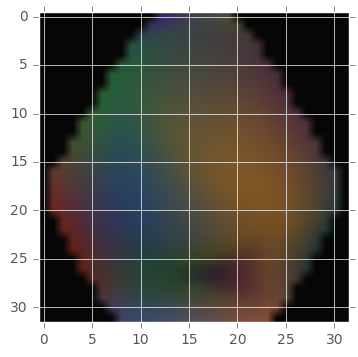

In [59]:
plt.imshow(images_1[3].T)

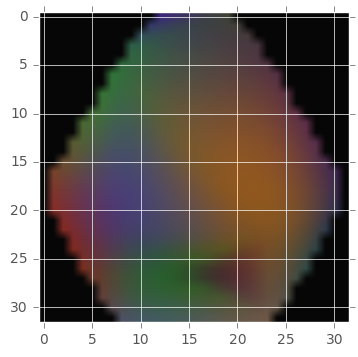

In [60]:
plt.imshow(images_1[4].T)

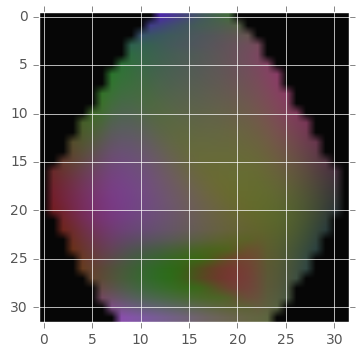

In [61]:
plt.imshow(images_1[5].T)

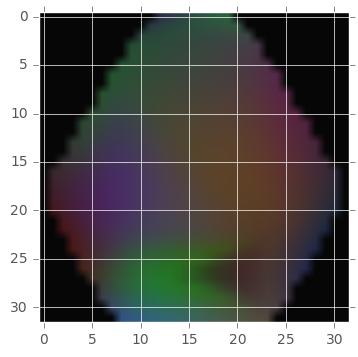

In [62]:
plt.imshow(images_1[6].T)

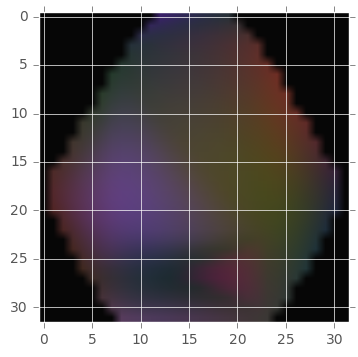

In [63]:
plt.imshow(images_1[7].T)

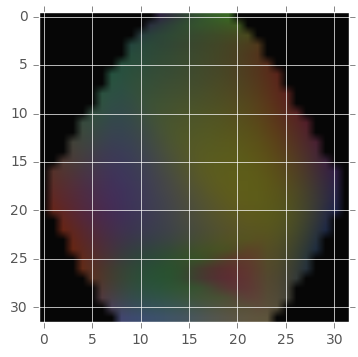

In [64]:
plt.imshow(images_1[8].T)

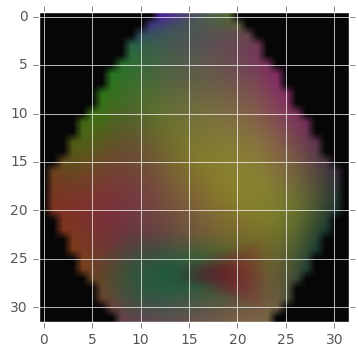

In [65]:
plt.imshow(images_1[20].T)

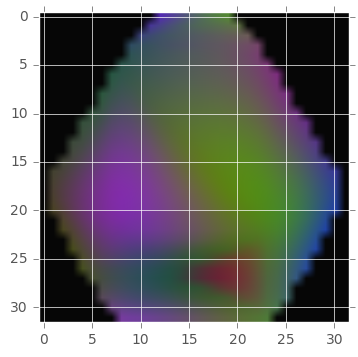

In [66]:
plt.imshow(images_1[90].T)